# Librerías

In [1]:
from sklearn.neighbors import kneighbors_graph
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             silhouette_score, normalized_mutual_info_score, adjusted_rand_score)
from sklearn import metrics
from tqdm import tqdm
import networkx as nx
import pandas as pd
import scanpy as sc
import numpy as np
import h5py 

from sklearn.decomposition import PCA

In [2]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

In [3]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

# Lectura de datos

In [4]:
with h5py.File('../../data/HumanLiver_counts_top5000.h5') as file:
    X = np.array(file['X'])
    y = np.array(file['Y'])

adata = sc.AnnData(X)
adata.obs['Group'] = y

print(f'Dimensiones: {adata.X.shape}')

Dimensiones: (8444, 4999)


# Procesamiento

In [5]:
adata = normalize(adata, size_factors=True, normalize_input=True, logtrans_input=True)

# Clusterización

In [15]:
def clustering(X, N, resolution, correlation_function): 
    pca = PCA(n_components=32)
    X = pca.fit_transform(X)

    knn_graph = kneighbors_graph(X, n_neighbors = N)

    for i,j in zip(knn_graph.nonzero()[0], knn_graph.nonzero()[1]):
        # Seleccionamos las células 
        cell_i, cell_j = X[i,:], X[j,:]

        # Calculamos la correlación
        correlacion = correlation_function(cell_i, cell_j).statistic
        knn_graph[i,j] = correlacion
    
    # Creación del grafo
    knn_graph = nx.from_scipy_sparse_array(knn_graph)
    communities = nx.community.louvain_communities(knn_graph, seed=123, resolution = resolution)

    # Predicción
    y_pred = np.zeros(len(knn_graph.nodes))

    for c in range(len(communities)):
        com_c = communities[c]
        for i in com_c:
            y_pred[i] = c

    return X, y_pred

In [16]:
def cluster_metrics(X, y, y_pred):
    # Supervised
    acc = np.round(cluster_acc(y, y_pred), 5)
    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(adjusted_rand_score(y, y_pred), 5)
    
    # Unsupervised
    chs = np.round(calinski_harabasz_score(X, y_pred), 5)
    dbs = np.round(davies_bouldin_score(X, y_pred), 5)
    ss = np.round(silhouette_score(X, y_pred), 5)

    metrics = {'acc': acc, 'nmi': nmi, 'ari': ari,
               'chs': chs, 'dbs': dbs, 'ss': ss, 
               'num_clusters': len(set(y_pred))}
    
    return metrics

# Búsqueda de hiperparámetros

In [57]:
import swifter

In [60]:
params = {
    'N': [5+i*2 for i in range(10)],
    'resolution': [0.1*i for i in range(1,11)], 
    'correlation_function': [pearsonr]
}

def completo(adata, N, r, cf):
    X, y_pred = clustering(adata.X, N = N, resolution = r, correlation_function = cf)
    results = cluster_metrics(X, y, y_pred)
    return results

results = pd.DataFrame()
comb = [(n, r) for n in params['N'] for r in params['resolution']]
results['N'] = [c[0] for c in comb]
results['r'] = [c[1] for c in comb]

solution = pd.DataFrame(list(results.swifter.apply(lambda row: completo(adata, int(row.N), row.r, pearsonr), axis = 1).values))
results = pd.concat([results,solution], axis = 1)

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
results

,N,r,acc,nmi,ari,chs,dbs,ss,num_clusters
0,5,0.1,0.82982,0.85340,0.76198,1383.25212,1.19795,0.29462,10
1,5,0.2,0.70263,0.80787,0.55536,1149.15395,1.27848,0.25315,15
2,5,0.3,0.62198,0.77384,0.45601,1111.42942,1.24977,0.26777,17
3,5,0.4,0.56111,0.75616,0.42782,1152.59395,1.21404,0.27467,18
4,5,0.5,0.52297,0.74097,0.37632,1186.79233,1.23702,0.26754,20
...,...,...,...,...,...,...,...,...,...
95,23,0.6,0.60469,0.76627,0.44607,1184.26193,1.17994,0.27986,18
96,23,0.7,0.56691,0.76444,0.43016,1191.49334,1.20338,0.28123,18
97,23,0.8,0.57094,0.75489,0.39725,1067.60962,1.29032,0.25535,18
98,23,0.9,0.56004,0.74433,0.38300,1082.77637,1.21211,0.26875,20


In [64]:
results.to_csv('results.csv')

In [66]:
import pickle
with open('results.pickle', 'wb') as file:
    pickle.dump( 
        file=file, obj = results)

# Veamos los resultados

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
with open('results.pickle', 'rb') as file:
    results = pickle.load(file)

<Axes: xlabel='acc', ylabel='Count'>

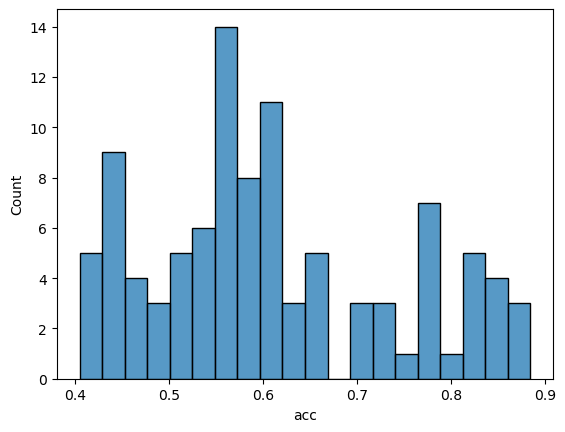

In [78]:
results = results.sort_values('acc', ascending=False)
sns.histplot(x = results.acc, bins = 20)

In [81]:
results[['acc', 'nmi', 'ari']].describe()

,acc,nmi,ari
count,100.000000,100.000000,100.000000
mean,0.609214,0.774772,0.477727
std,0.128630,0.046504,0.149721
min,0.405140,0.692930,0.287170
25%,0.522203,0.742385,0.374225
50%,0.579705,0.765480,0.439545
75%,0.704673,0.813567,0.568845
max,0.884770,0.884670,0.810300


In [100]:
results[['chs', 'dbs']]

,chs,dbs
51,1301.76574,1.07943
41,1312.34862,1.09541
61,1310.28453,1.16042
71,1391.01437,1.17685
31,1198.66620,1.25033
...,...,...
39,1135.44771,1.30088
28,1091.83100,1.30745
8,1007.05068,1.32143
7,1045.75548,1.34170


Correlación accuracy - nmi: 0.992
Correlación accuracy - ari: 0.981
Correlación accuracy - ss: 0.631
Correlación accuracy - chs: 0.719
Correlación accuracy - dbs: -0.621


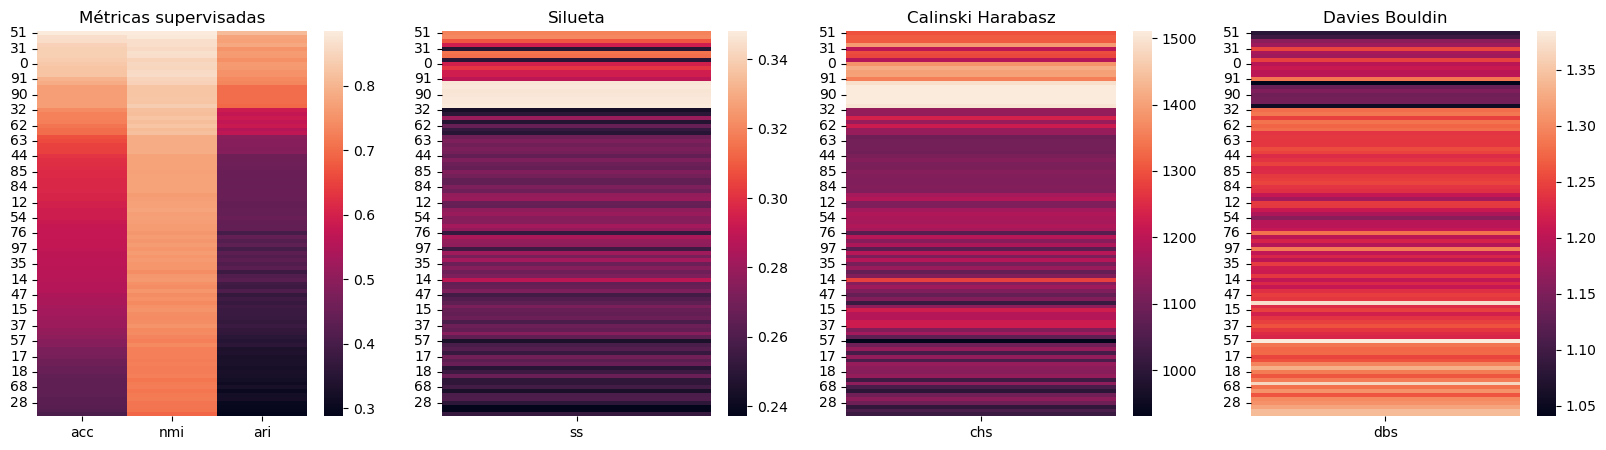

In [109]:
# Comparemos las métricas supervisadas y no supervisadas

fig, axes = plt.subplots(ncols = 4, figsize = (20,5))
sns.heatmap(results[['acc', 'nmi', 'ari']], ax = axes[0]).set(title = 'Métricas supervisadas')
sns.heatmap(results[['ss']], ax = axes[1]).set(title = 'Silueta')
sns.heatmap(results[['chs']], ax = axes[2]).set(title = 'Calinski Harabasz')
sns.heatmap(results[['dbs']], ax = axes[3]).set(title = 'Davies Bouldin')

# Correlaciones con accuracy
for col in ['nmi', 'ari', 'ss', 'chs', 'dbs']:
    corr = np.round(pearsonr(results.acc, results[col]).statistic,3)
    print(f'Correlación accuracy - {col}: {corr}')

In [111]:
results.columns

Index(['N', 'r', 'acc', 'nmi', 'ari', 'chs', 'dbs', 'ss', 'num_clusters'], dtype='object')

Correlación accuracy - N: 0.188
Correlación accuracy - r: -0.911


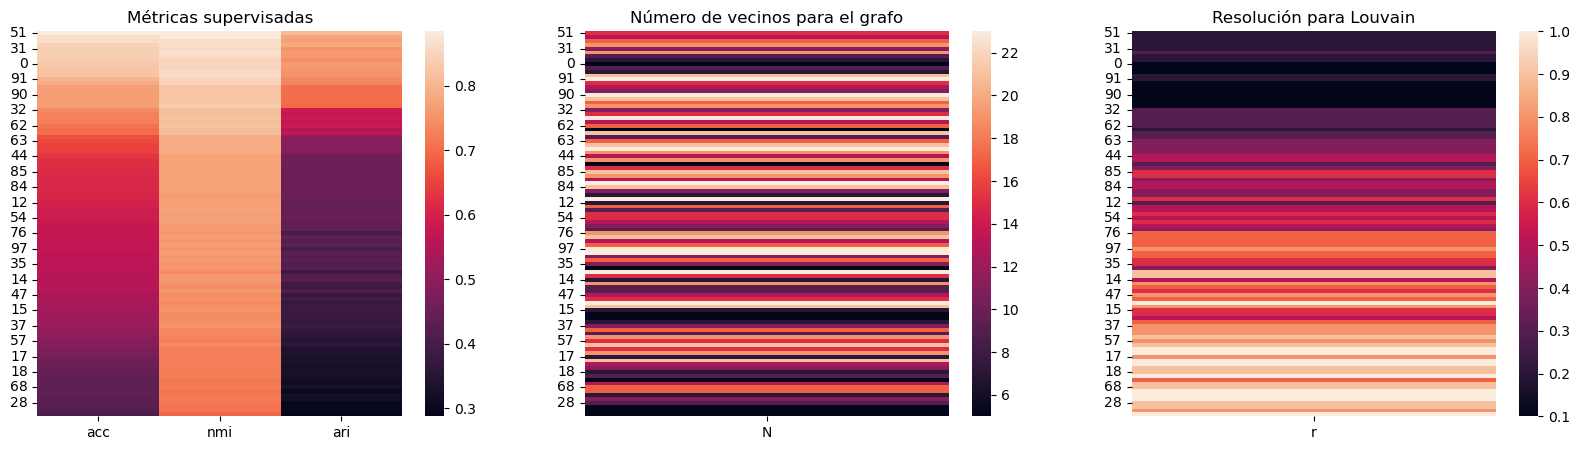

In [113]:
# Comparemos las métricas supervisadas con parámetros - Parece que entre menor la resolución es mejor el resultado

fig, axes = plt.subplots(ncols = 3, figsize = (20,5))
sns.heatmap(results[['acc', 'nmi', 'ari']], ax = axes[0]).set(title = 'Métricas supervisadas')
sns.heatmap(results[['N']], ax = axes[1]).set(title = 'Número de vecinos para el grafo')
sns.heatmap(results[['r']], ax = axes[2]).set(title = 'Resolución para Louvain')

# Correlaciones con accuracy
for col in ['N', 'r']:
    corr = np.round(pearsonr(results.acc, results[col]).statistic,3)
    print(f'Correlación accuracy - {col}: {corr}')

# Ahora vamos a probar sin PCA, sino con los resultados del autoencoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from graph_based_corr import * 
path_z = '../../results/HumanLiver_counts_top5000/Z.csv'
with h5py.File('../../data/HumanLiver_counts_top5000.h5') as file:
    X = np.array(file['X'])
    y = np.array(file['Y'])

In [3]:
results = main_no_pca(path_z, y)

100%|██████████| 100/100 [1:01:13<00:00, 36.73s/it]


In [4]:
with open('results_AE.pickle', 'wb') as file:
    pickle.dump( file=file, obj = results)

<Axes: xlabel='acc', ylabel='Count'>

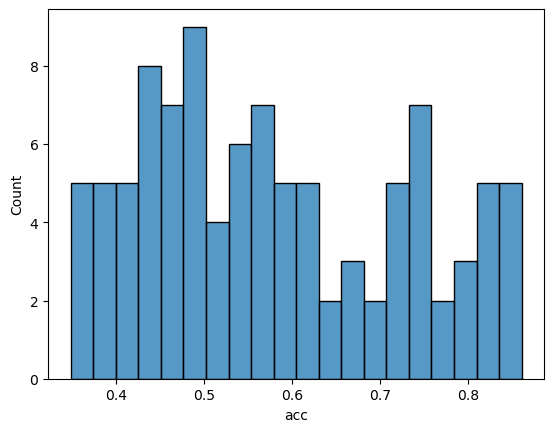

In [5]:
results = results.sort_values('acc', ascending=False)
sns.histplot(x = results.acc, bins = 20)

In [8]:
results.head()

,N,r,acc,nmi,ari,chs,dbs,ss,num_clusters
31,11,0.2,0.86132,0.86685,0.76072,3575.59733,0.99061,0.38050,13
11,7,0.2,0.85955,0.85842,0.75516,3496.86517,0.99910,0.37713,13
41,13,0.2,0.85919,0.86262,0.75647,3611.21540,0.99064,0.37969,13
71,19,0.2,0.85611,0.84728,0.74785,3558.90044,1.07870,0.36961,12
61,17,0.2,0.85564,0.85602,0.75100,3485.69028,0.99483,0.37750,13


Correlación accuracy - nmi: 0.987
Correlación accuracy - ari: 0.972
Correlación accuracy - ss: 0.755
Correlación accuracy - chs: 0.676
Correlación accuracy - dbs: -0.11


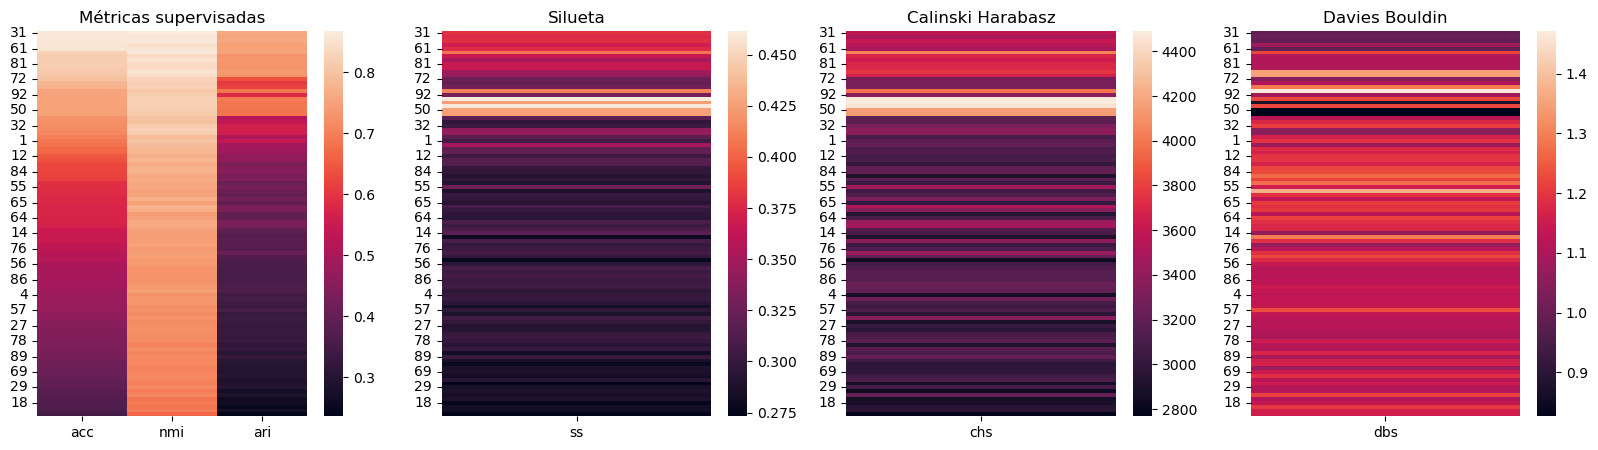

In [6]:
# Comparemos las métricas supervisadas y no supervisadas

fig, axes = plt.subplots(ncols = 4, figsize = (20,5))
sns.heatmap(results[['acc', 'nmi', 'ari']], ax = axes[0]).set(title = 'Métricas supervisadas')
sns.heatmap(results[['ss']], ax = axes[1]).set(title = 'Silueta')
sns.heatmap(results[['chs']], ax = axes[2]).set(title = 'Calinski Harabasz')
sns.heatmap(results[['dbs']], ax = axes[3]).set(title = 'Davies Bouldin')

# Correlaciones con accuracy
for col in ['nmi', 'ari', 'ss', 'chs', 'dbs']:
    corr = np.round(pearsonr(results.acc, results[col]).statistic,3)
    print(f'Correlación accuracy - {col}: {corr}')

Correlación accuracy - N: 0.171
Correlación accuracy - r: -0.934


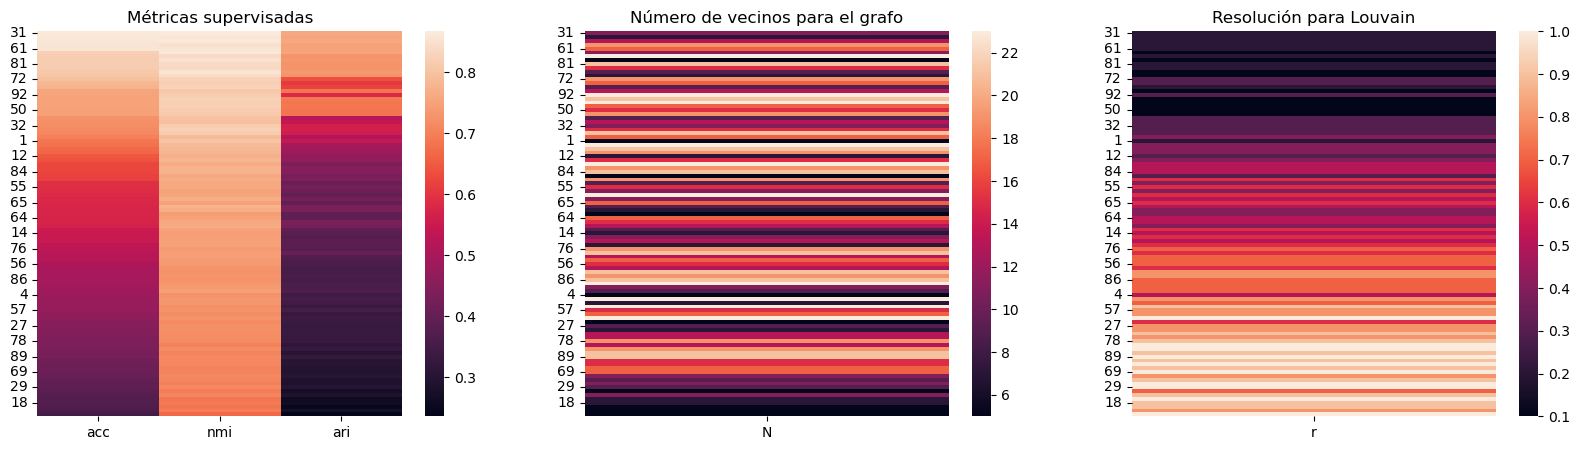

In [7]:
# Comparemos las métricas supervisadas con parámetros - Parece que entre menor la resolución es mejor el resultado

fig, axes = plt.subplots(ncols = 3, figsize = (20,5))
sns.heatmap(results[['acc', 'nmi', 'ari']], ax = axes[0]).set(title = 'Métricas supervisadas')
sns.heatmap(results[['N']], ax = axes[1]).set(title = 'Número de vecinos para el grafo')
sns.heatmap(results[['r']], ax = axes[2]).set(title = 'Resolución para Louvain')

# Correlaciones con accuracy
for col in ['N', 'r']:
    corr = np.round(pearsonr(results.acc, results[col]).statistic,3)
    print(f'Correlación accuracy - {col}: {corr}')